# Finetuning on Reddit data

In [1]:
import sys, os
sys.path.insert(0, os.path.join(os.path.abspath(os.pardir)))

import numpy as np
from keras.preprocessing import sequence
from sklearn.cross_validation import train_test_split
from src.models.convnets import ConvolutionalNet
from src.preprocessors.preprocess_text import clean, mark_unknown_words
from src.train import words_to_indices, SEQUENCE_LENGTH, EMBEDDING_DIMENSION, MODEL_FILE

Using TensorFlow backend.


In [2]:
vocabulary = open("../data/vocabulary.txt").read().split("\n")
inverse_vocabulary = dict((word, i) for i, word in enumerate(vocabulary))

clickbait = open("../data/reddit/clickbait-reddit.txt").read() + "\n"
clickbait += open("../data/reddit/clickbait-top-reddit.txt").read()
clickbait = clean(clickbait)
clickbait = clickbait.split("\n")
clickbait = list(set(clickbait))
clickbait = [mark_unknown_words(vocabulary, title) for title in clickbait]

print "Clickbait"
print "-" * 50
for i, each in enumerate(clickbait[:5]):
    print "{0}. {1}".format(i+1, each)
print "-" * 50

genuine = open("../data/reddit/genuine-reddit.txt").read() + "\n"
genuine += open("../data/reddit/news-reddit.txt").read()
genuine = clean(genuine)
genuine = genuine.split("\n")
genuine = list(set(genuine))
genuine = [mark_unknown_words(vocabulary, title) for title in genuine]

print "Genuine"
print "-" * 50
for i, each in enumerate(genuine[:5]):
    print "{0}. {1}".format(i+1, each)
print "-" * 50


Clickbait
--------------------------------------------------
1. mom <UNK> a tough <UNK> after she starts <UNK> her daughter in the car
2. if you see a $ 1 0 0 bill on your car , be <UNK> of this scam
3. <UNK> an iphone 7 with an iphone <UNK> case
4. she knows i lied
5. bernie sanders could replace president trump with little known <UNK>
--------------------------------------------------
Genuine
--------------------------------------------------
1. <UNK> says <UNK> my great grandparents were denied <UNK> in australia & amp ; were murdered in <UNK> <UNK> - the jew terrorists who were <UNK> ' about in <UNK> <UNK> as the <UNK> twin <UNK> came down on 9 1 1 have had <UNK> <UNK> <UNK> in <UNK> since the day of the outrage - <UNK> <UNK> / steven <UNK>
2. despite what you might think , <UNK> are not stupid
3. <UNK> challenge : the real story of a <UNK> military exercise and its legacy
4. death toll now 7 5 in <UNK> <UNK> , brazil as <UNK> chaos <UNK>
5. <UNK> bans the daily mail as a source fo

In [3]:
C = sequence.pad_sequences([words_to_indices(inverse_vocabulary, sentence.split()) for sentence in clickbait], maxlen=SEQUENCE_LENGTH)
G = sequence.pad_sequences([words_to_indices(inverse_vocabulary, sentence.split()) for sentence in genuine], maxlen=SEQUENCE_LENGTH)

X = np.concatenate([C, G], axis=0)
y = np.array([[1] * C.shape[0] + [0] * G.shape[0]], dtype=np.int32).T
p = np.random.permutation(y.shape[0])
X = X[p]
y = y[p]

X_train, X_test, y_train, y_test =  train_test_split(X, y, stratify=y)

In [4]:
params = dict(vocabulary_size=len(vocabulary), embedding_dimension=EMBEDDING_DIMENSION, input_length=SEQUENCE_LENGTH)
model = ConvolutionalNet(**params)

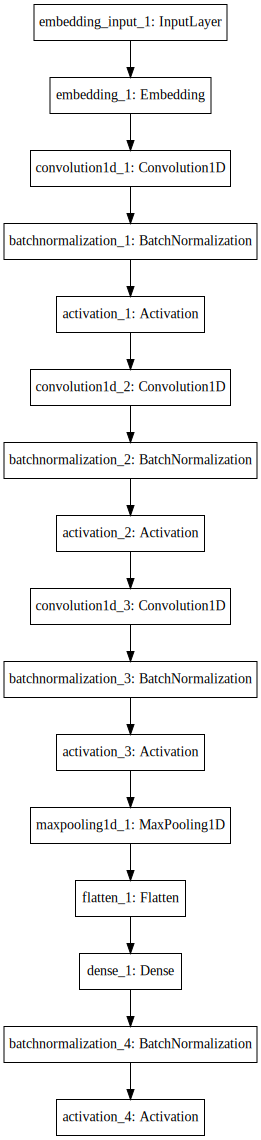

In [5]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot


SVG(model_to_dot(model).create(prog="dot", format="svg"))

In [22]:
from keras.layers import Convolution1D, Dense
from keras.regularizers import activity_l1l2
from keras.optimizers import SGD, Adam

model.load_weights("../models/detector.h5")

for layer in model.layers:
    layer.trainable = False

for layer in model.layers[1:]:
    if type(layer) == Dense or type(layer) == Convolution1D:
        layer.W_regularizer=None
        layer.activity_regularizer=activity_l1l2(0.05)
    layer.trainable = True



model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])

In [23]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, nb_epoch=5, shuffle=True)

Train on 2541 samples, validate on 848 samples
Epoch 1/5
2541/2541 [==============================] - 4s - loss: 0.5413 - acc: 0.7824 - val_loss: 0.5357 - val_acc: 0.8066
Epoch 2/5
2541/2541 [==============================] - 1s - loss: 0.3778 - acc: 0.8512 - val_loss: 0.4626 - val_acc: 0.8160
Epoch 3/5
2541/2541 [==============================] - 1s - loss: 0.3174 - acc: 0.8835 - val_loss: 0.4603 - val_acc: 0.8031
Epoch 4/5
2541/2541 [==============================] - 1s - loss: 0.2693 - acc: 0.9071 - val_loss: 0.4570 - val_acc: 0.8208
Epoch 5/5
2541/2541 [==============================] - 1s - loss: 0.2418 - acc: 0.9260 - val_loss: 0.4623 - val_acc: 0.8125


In [24]:
model.save_weights("../models/detector.finetuned.h5")